# This script was used to see how electrodes correlate across subjects. See another from: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006769
#

High CC means phase-locking;

In [1]:
import numpy as np

from gesture.utils import get_epoch,get_good_channels
import matplotlib.pyplot as plt
import scipy.io
from gesture.config import *
import h5py
import pandas as pd
from gesture.utils import sub_sf_dict

2024-08-20 14:45:18 - Start Program

pre_all: Running from CMD.
common_dl.py: Using CUDA.


In [2]:
filename=meta_dir+'ele_anat_position.npy'
ele = np.load(filename,allow_pickle=True).item()
good_channels=get_good_channels()

In [3]:
sid=2
info_dict=sub_sf_dict()
sf=info_dict[str(sid)]

tmin=0
tmax=0.5
epochs=get_epoch(sid, sf,scaler='no',trigger='EMG',tmin=tmin,tmax=tmax)
#epoch1=epochs['1']# 20 trials. 8001 time points per trial for 8s.
#epoch2=epochs['2']
epoch3=epochs['3'] # simple grasp
total_ch_number=len(epoch3.info.ch_names)
#epoch4=epochs['4']

In [4]:
# mark bad channels
good_channel=good_channels['sid'+str(sid)] # start from 1 (Matlab)
good_channel=[i-1 for i in good_channel]
bad_channels_ind=[i for i in range(len(epoch3.ch_names)-7) if i not in good_channel]
bad_channels=[epoch3.ch_names[c] for c in bad_channels_ind]
epoch3.load_data()
epoch3.drop_channels(bad_channels)


Number of events,20
Events,3: 20
Time range,0.000 – 0.500 s
Baseline,off


### CC within trials from the same subject

Mean cc is low; CC is high only for some channels. It means only few channels resemble to each other, while most of them oscilate differently.

In [5]:
epoch=epoch3.copy().load_data().filter(l_freq=0.1,h_freq=3,picks=['eeg'])
matrixes=[]
data=epoch.get_data(picks=['eeg'])
ch_number=data.shape[1]
for trial in data: # trial: (115, 1000)
    dataframe=pd.DataFrame(data=trial.transpose(),columns=[str(i) for i in range(ch_number)])
    matrix = dataframe.corr(method='pearson').to_numpy()
    matrix[np.diag_indices_from(matrix)] = 0.
    matrixes.append(matrix)
matrix_avg=np.average(np.asarray(matrixes),axis=0)

In [9]:
a=matrix_avg.reshape(-1)
b=[abs(i) for i in a]
print(sum(b)/(len(b)-ch_number)) 

0.2254155951168249


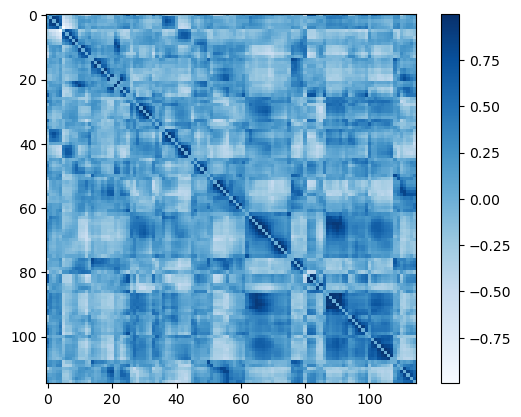

In [7]:
%matplotlib inline
#%matplotlib qt
#%gui qt
plt.imshow(matrix_avg, cmap='Blues')
plt.colorbar()
plt.show()

### CC across trials for individual channel from the same subject.

For one particular channel (81), the ploted high CC means that this channel oscillate very stable across trials.


In [10]:
epoch=epoch3.copy().load_data().filter(l_freq=0.1,h_freq=3,picks=['eeg'])
data=epoch.get_data(picks=['eeg']) # (20, 115, 1001)
ch_number=data.shape[1]

In [11]:
matrixes=[]
ch_mean=[]
for ch in range(ch_number): # trial: (115, 1000)
    dataframe=pd.DataFrame(data=data[:,ch,:].squeeze().transpose())
    matrix = dataframe.corr(method='pearson').to_numpy()
    matrix[np.diag_indices_from(matrix)] = 0.
    matrixes.append(matrix)
    ch_mean.append(matrix.sum()/(20*20-20)) # diagonal is zero
matrix_avg=np.average(np.asarray(matrixes),axis=0) # 20*20

In [12]:
sum(ch_mean)/len(ch_mean)

0.15288299670780878

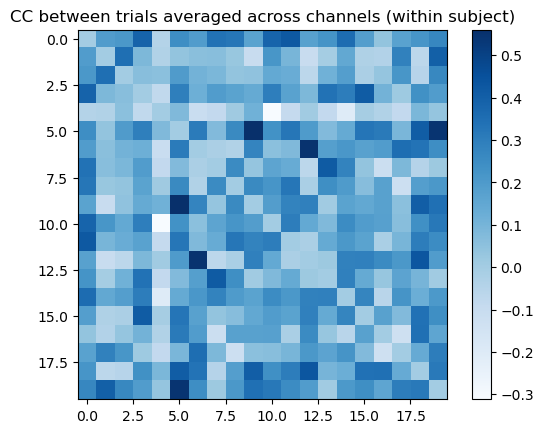

In [13]:
%matplotlib inline
#%matplotlib qt
#%gui qt
plt.imshow(matrix_avg, cmap='Blues')
plt.title("CC between trials averaged across channels (within subject)")
plt.colorbar()
plt.show() 

# This plot actually meaningless, because each channel behavior very differently and this plot is the average across channels;
# This reconfirms that only few of them oscillates stable across trials.

In [19]:
ch_mean.index(max(ch_mean)) #maximum 0.68

81

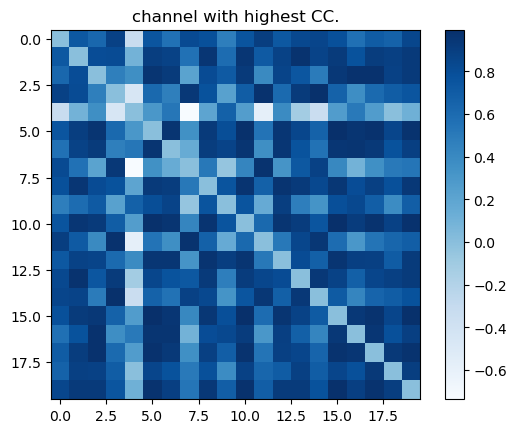

In [17]:
%matplotlib inline
#%matplotlib qt
#%gui qt
plt.imshow(matrixes[81], cmap='Blues')
plt.title("cross-trial CC of channel with the highest CC.")
plt.colorbar()
plt.show()

In [25]:
a=matrixes[81].reshape(-1)
b=matrixes[81].shape[0]
print('Mean CC: '+ str(sum(a)/(b*b-b)))

Mean CC: 0.6878013636526463


## check CC across subjects. CC with trigger='EMG' is much higher than CC with trigger='EEG', which means group analysis is possible.

In [4]:
from gesture.group_analysis.util import calculate_CC
import matplotlib.pyplot as plt

sid1=2
sid2=10
sf1=1000
sf2=1000

In [11]:
matrixes,ordered_ch_names=calculate_CC(sid1, sf1, sid2, sf2, f1=1, f2=3,trigger='EMG',re_ordered=True,duration=2)

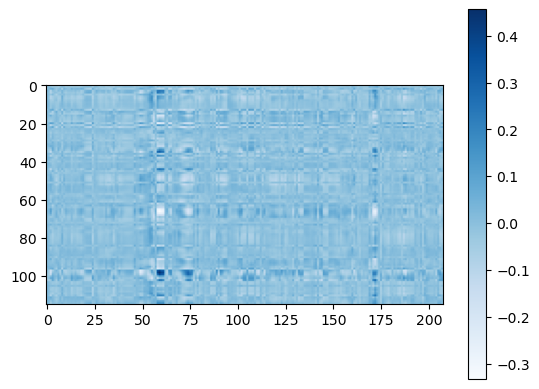

In [12]:
# trigger=EEG+random_shift
%matplotlib inline
fig,ax=plt.subplots()
im=ax.imshow(matrixes,cmap='Blues')
fig.colorbar(im)
plt.show() # 0.5s:0.35; 1s:0.35; sid2+10:[1s:0.55,2s:0.45]

In [13]:
matrixes,ordered_ch_names=calculate_CC(sid1, sf1, sid2, sf2, f1=1, f2=3,trigger='EEG',re_ordered=True,duration=2,random_shift=[500,1000])

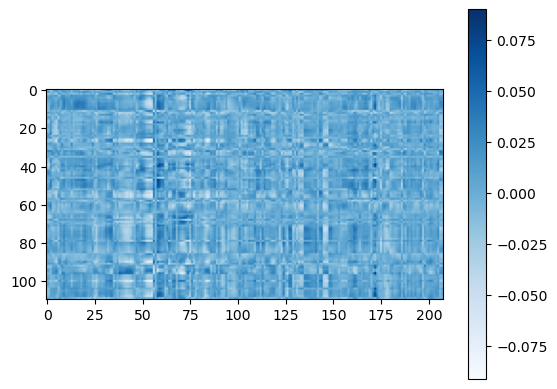

In [14]:
%matplotlib inline
# trigger=EMG
fig,ax=plt.subplots()
im=ax.imshow(matrixes,cmap='Blues')
fig.colorbar(im)
plt.show() # 0.07